# Complete Accuracy Evaluation Pipeline - Kaggle Edition
## Day 2: Independent Accuracy Measurement System

**Purpose:** Evaluate model accuracy for FP32, FP16, INT8 independently of energy measurements

**Works NOW for:** FP32 baseline  
**Ready for:** FP16/INT8 when Thomas provides models  
**Integrates with:** Krishna's energy data when available

---

**Run this notebook to:**
1. Evaluate model accuracy
2. Generate confusion matrices
3. Compute per-class statistics
4. Log results to CSV
5. Compare multiple precisions

## Part 1: Setup and Dependencies

In [13]:
!pip install -q transformers datasets scikit-learn seaborn

print("Dependencies installed")

Dependencies installed


In [14]:

import torch
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional

from transformers import DistilBertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

print("All imports successful")

All imports successful


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB


## Part 2: Core Classes and Functions

This section defines all the evaluation functionality.

In [16]:
@dataclass
class AccuracyResults:
    """Container for accuracy evaluation results."""
    precision_type: str
    accuracy: float
    num_correct: int
    num_total: int
    per_class_accuracy: Dict[int, float]
    confusion_matrix: np.ndarray
    inference_time: float
    samples_per_second: float
    batch_size: int
    num_batches: int
    
    def to_dict(self):
        """Convert to dictionary for JSON serialization."""
        result = asdict(self)
        result['confusion_matrix'] = result['confusion_matrix'].tolist()
        return result
    
    def summary(self) -> str:
        """Get a text summary of results."""
        lines = [
            f"{'='*60}",
            f"Accuracy Evaluation: {self.precision_type}",
            f"{'='*60}",
            f"Overall Accuracy:    {self.accuracy*100:.2f}% ({self.num_correct}/{self.num_total})",
            f"Inference Time:      {self.inference_time:.3f} seconds",
            f"Throughput:          {self.samples_per_second:.2f} samples/sec",
            f"Batch Configuration: {self.num_batches} batches × {self.batch_size}",
            f"",
            f"Per-Class Accuracy:",
        ]
        for label, acc in self.per_class_accuracy.items():
            lines.append(f"  Class {label}: {acc*100:.2f}%")
        lines.append(f"{'='*60}")
        return "\n".join(lines)


class AccuracyEvaluator:
    """Complete accuracy evaluation system."""
    
    def __init__(self, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"AccuracyEvaluator initialized on {self.device}")
    
    def evaluate(
        self,
        model: torch.nn.Module,
        dataset,
        batch_size: int = 8,
        precision_type: str = 'FP32',
        warmup_batches: int = 2
    ) -> AccuracyResults:
        """Evaluate model accuracy on dataset."""
        model.eval()
        
        # Warmup
        print(f"Warming up with {warmup_batches} batches...")
        with torch.no_grad():
            for i, batch in enumerate(dataset.get_batch(batch_size)):
                if i >= warmup_batches:
                    break
                _ = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
        
        if self.device.type == 'cuda':
            torch.cuda.synchronize()
        
        # Actual evaluation
        print(f"Running evaluation on {len(dataset)} samples...")
        all_predictions = []
        all_labels = []
        num_batches = 0
        
        start_time = time.perf_counter()
        
        with torch.no_grad():
            for batch in dataset.get_batch(batch_size):
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                predictions = logits.argmax(dim=-1).cpu().numpy()
                labels = batch['labels'].cpu().numpy()
                
                all_predictions.extend(predictions)
                all_labels.extend(labels)
                num_batches += 1
        
        if self.device.type == 'cuda':
            torch.cuda.synchronize()
        
        end_time = time.perf_counter()
        inference_time = end_time - start_time
        
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        
        num_correct = (all_predictions == all_labels).sum()
        num_total = len(all_labels)
        accuracy = num_correct / num_total
        
        per_class_acc = self._compute_per_class_accuracy(all_predictions, all_labels)
        
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        
        samples_per_second = num_total / inference_time if inference_time > 0 else 0
        
        return AccuracyResults(
            precision_type=precision_type,
            accuracy=accuracy,
            num_correct=int(num_correct),
            num_total=num_total,
            per_class_accuracy=per_class_acc,
            confusion_matrix=conf_matrix,
            inference_time=inference_time,
            samples_per_second=samples_per_second,
            batch_size=batch_size,
            num_batches=num_batches
        )
    
    def _compute_per_class_accuracy(self, predictions: np.ndarray, labels: np.ndarray) -> Dict[int, float]:
        """Compute accuracy per class."""
        unique_labels = np.unique(labels)
        per_class = {}
        
        for label in unique_labels:
            mask = labels == label
            class_correct = (predictions[mask] == labels[mask]).sum()
            class_total = mask.sum()
            per_class[int(label)] = float(class_correct / class_total) if class_total > 0 else 0.0
        
        return per_class
    
    def compute_batch_accuracies(self, model, dataset, batch_size: int = 8) -> List[float]:
        """Compute accuracy for each batch individually."""
        model.eval()
        batch_accuracies = []
        
        with torch.no_grad():
            for batch in dataset.get_batch(batch_size):
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask']
                )
                
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                predictions = logits.argmax(dim=-1)
                
                correct = (predictions == batch['labels']).sum().item()
                total = len(batch['labels'])
                batch_acc = correct / total
                batch_accuracies.append(batch_acc)
        
        return batch_accuracies
    
    def compare_precisions(self, results_list: List[AccuracyResults]) -> Dict:
        """Compare accuracy across different precision levels."""
        comparison = {
            'precisions': [],
            'accuracies': [],
            'throughputs': [],
            'correct': [],
            'total': []
        }
        
        for result in results_list:
            comparison['precisions'].append(result.precision_type)
            comparison['accuracies'].append(result.accuracy)
            comparison['throughputs'].append(result.samples_per_second)
            comparison['correct'].append(result.num_correct)
            comparison['total'].append(result.num_total)
        
        best_idx = np.argmax(comparison['accuracies'])
        worst_idx = np.argmin(comparison['accuracies'])
        
        comparison['best'] = {
            'precision': comparison['precisions'][best_idx],
            'accuracy': comparison['accuracies'][best_idx]
        }
        comparison['worst'] = {
            'precision': comparison['precisions'][worst_idx],
            'accuracy': comparison['accuracies'][worst_idx]
        }
        
        best_acc = comparison['accuracies'][best_idx]
        comparison['accuracy_drops'] = {
            prec: (best_acc - acc) * 100
            for prec, acc in zip(comparison['precisions'], comparison['accuracies'])
        }
        
        return comparison
    
    def plot_confusion_matrix(
        self,
        results: AccuracyResults,
        save_path: Optional[str] = None,
        class_names: Optional[List[str]] = None
    ):
        """Plot confusion matrix."""
        fig, ax = plt.subplots(figsize=(8, 6))
        
        cm = results.confusion_matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names or range(len(cm)),
            yticklabels=class_names or range(len(cm)),
            ax=ax
        )
        
        ax.set_title(f'Confusion Matrix: {results.precision_type}', fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_xlabel('Predicted Label', fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Confusion matrix saved to {save_path}")
        
        plt.show()
    
    def save_results(self, results: AccuracyResults, output_path: str):
        """Save results to JSON file."""
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        with open(output_path, 'w') as f:
            json.dump(results.to_dict(), f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
    
    def load_results(self, input_path: str) -> AccuracyResults:
        """Load results from JSON file."""
        with open(input_path, 'r') as f:
            data = json.load(f)
        
        data['confusion_matrix'] = np.array(data['confusion_matrix'])
        return AccuracyResults(**data)


def compute_accuracy_statistics(accuracies: List[float]) -> Dict[str, float]:
    """Compute statistical summary of accuracies."""
    accuracies_array = np.array(accuracies)
    
    return {
        'mean': float(np.mean(accuracies_array)),
        'std': float(np.std(accuracies_array)),
        'min': float(np.min(accuracies_array)),
        'max': float(np.max(accuracies_array)),
        'median': float(np.median(accuracies_array)),
        'ci_95': float(1.96 * np.std(accuracies_array) / np.sqrt(len(accuracies_array)))
    }


def print_classification_report(predictions: np.ndarray, labels: np.ndarray, class_names: Optional[List[str]] = None):
    """classification report."""
    report = classification_report(labels, predictions, target_names=class_names, digits=4)
    print("\nClassification Report:")
    print("=" * 60)
    print(report)
    print("=" * 60)


print(" Accuracy evaluation classes defined")

 Accuracy evaluation classes defined


In [17]:
class ResultsLogger:
    """Structured logging system for experimental results."""
    
    def __init__(self, output_dir: str = '/kaggle/working/results'):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.results = []
        print(f"ResultsLogger initialized. Output: {self.output_dir}")
    
    def log_result(
        self,
        precision: str,
        batch_size: int,
        seq_length: int,
        accuracy: float,
        latency: float,
        avg_power: Optional[float] = None,
        energy: Optional[float] = None,
        throughput: Optional[float] = None,
        num_samples: int = 50,
        notes: str = ""
    ):
        """Log a single experimental result."""
        if accuracy <= 1.0:
            accuracy = accuracy * 100.0
        
        if throughput is None and latency > 0:
            throughput = num_samples / latency
        
        if energy is None and avg_power is not None and latency > 0:
            energy = avg_power * latency
        
        energy_per_sample = energy / num_samples if energy and num_samples > 0 else None
        
        result = {
            'timestamp': datetime.now().isoformat(),
            'precision': precision,
            'batch_size': batch_size,
            'seq_length': seq_length,
            'num_samples': num_samples,
            'accuracy_%': round(accuracy, 2),
            'latency_s': round(latency, 4),
            'throughput_samples_s': round(throughput, 2) if throughput else None,
            'avg_power_w': round(avg_power, 2) if avg_power else None,
            'energy_j': round(energy, 4) if energy else None,
            'energy_per_sample_mj': round(energy_per_sample * 1000, 4) if energy_per_sample else None,
            'notes': notes
        }
        
        self.results.append(result)
        print(f"✓ Logged: {precision} | Acc: {accuracy:.2f}% | Latency: {latency:.4f}s")
    
    def get_dataframe(self) -> pd.DataFrame:
        """Get results as pandas DataFrame."""
        return pd.DataFrame(self.results)
    
    def save_csv(self, filename: str = 'results.csv'):
        """Save results to CSV file."""
        df = self.get_dataframe()
        output_path = self.output_dir / filename
        df.to_csv(output_path, index=False)
        print(f"✓ Results saved to {output_path}")
        return output_path
    
    def save_json(self, filename: str = 'results.json'):
        """Save results to JSON file."""
        output_path = self.output_dir / filename
        with open(output_path, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"✓ Results saved to {output_path}")
        return output_path
    
    def print_summary(self):
        """Print summary of logged results."""
        if not self.results:
            print("No results logged yet.")
            return
        
        df = self.get_dataframe()
        
        print("\n" + "="*70)
        print("RESULTS SUMMARY")
        print("="*70)
        
        print(f"\nTotal experiments: {len(df)}")
        print(f"Precisions: {df['precision'].unique().tolist()}")
        print(f"Batch sizes: {sorted(df['batch_size'].unique().tolist())}")
        
        print("\nAccuracy by Precision:")
        print("-"*70)
        for precision in df['precision'].unique():
            precision_df = df[df['precision'] == precision]
            mean_acc = precision_df['accuracy_%'].mean()
            print(f"  {precision:6s}: {mean_acc:6.2f}%")
        
        if 'energy_j' in df.columns and df['energy_j'].notna().any():
            print("\nEnergy by Precision:")
            print("-"*70)
            for precision in df['precision'].unique():
                precision_df = df[df['precision'] == precision]
                mean_energy = precision_df['energy_j'].mean()
                if pd.notna(mean_energy):
                    print(f"  {precision:6s}: {mean_energy:8.4f} J")
        
        print("="*70 + "\n")


def create_results_template(output_path: str = '/kaggle/working/results_template.csv'):
    """Create an empty results template CSV file."""
    template = pd.DataFrame(columns=[
        'timestamp', 'precision', 'batch_size', 'seq_length', 'num_samples',
        'accuracy_%', 'latency_s', 'throughput_samples_s', 'avg_power_w',
        'energy_j', 'energy_per_sample_mj', 'notes'
    ])
    
    template.to_csv(output_path, index=False)
    print(f"✓ Results template saved to {output_path}")
    return output_path


print(" Results logging classes defined")

 Results logging classes defined


In [18]:
# PART 2.5: CREATE PRE-TOKENIZED DATASET (Day 1 Code Inline)

from pathlib import Path
import torch
from transformers import DistilBertTokenizer
from datasets import load_dataset
import json

print("\n" + "="*70)
print("PART 2.5: DATASET PREPARATION")
print("="*70)

data_path = Path('/kaggle/working/tokenized_data')

if not data_path.exists():
    print("\nCreating pre-tokenized dataset...")
    print("This replicates Day 1 functionality inline")
    print("-"*70)
    
    data_path.mkdir(parents=True, exist_ok=True)
    
    print("\n[1/5] Loading DistilBERT tokenizer...")
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    print("Tokenizer loaded")
    
    print("\n[2/5] Loading SST-2 validation set...")
    dataset_raw = load_dataset("glue", "sst2", split="validation")
    print(f"Loaded {len(dataset_raw)} total examples")
    
    print("\n[3/5] Selecting 50 examples (seed=42)...")
    dataset_raw = dataset_raw.shuffle(seed=42).select(range(50))
    print("Selected 50 examples")
    
    print("\n[4/5] Tokenizing with max_length=128...")
    texts = [example['sentence'] for example in dataset_raw]
    labels = [example['label'] for example in dataset_raw]
    
    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    print("✓ Tokenization complete")
    
    print("\n[5/5] Saving to /kaggle/working/tokenized_data/...")
    torch.save(encodings['input_ids'], data_path / 'input_ids.pt')
    torch.save(encodings['attention_mask'], data_path / 'attention_mask.pt')
    torch.save(labels_tensor, data_path / 'labels.pt')
    
    metadata = {
        'num_samples': 50,
        'max_length': 128,
        'dataset_name': 'sst2',
        'num_labels': 2,
        'seed': 42,
        'tokenizer': 'distilbert-base-uncased',
    }
    
    with open(data_path / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("Files saved")
    
    print("\n" + "="*70)
    print("DATASET CREATED SUCCESSFULLY!")
    print("="*70)
    
    print("\nDataset Summary:")
    print(f"  Location:        {data_path}")
    print(f"  Samples:         50")
    print(f"  Sequence Length: 128 tokens")
    print(f"  Classes:         2 (Negative=0, Positive=1)")
    print(f"  Seed:            42 (reproducible)")
    
    print("\nFiles Created:")
    for file in sorted(data_path.glob('*')):
        size = file.stat().st_size / 1024
        print(f"  • {file.name:25s} {size:8.2f} KB")
    
    print("\nFirst 3 Examples:")
    for i in range(min(3, len(texts))):
        print(f"\n  Example {i+1}:")
        print(f"    Text:  {texts[i][:60]}...")
        print(f"    Label: {labels[i]} ({'Positive' if labels[i]==1 else 'Negative'})")
    
    print("\n" + "="*70)
    print("Ready for Part 3: Load Pre-tokenized Dataset")
    print("="*70 + "\n")
    
else:
    print("\n✓ Dataset already exists at /kaggle/working/tokenized_data/")
    print("\nExisting files:")
    for file in sorted(data_path.glob('*')):
        size = file.stat().st_size / 1024
        print(f"  • {file.name:25s} {size:8.2f} KB")
    print()


PART 2.5: DATASET PREPARATION

✓ Dataset already exists at /kaggle/working/tokenized_data/

Existing files:
  • attention_mask.pt            51.19 KB
  • input_ids.pt                 51.16 KB
  • labels.pt                     1.52 KB
  • metadata.json                 0.14 KB



## Part 3: Load Pre-tokenized Dataset

Use the dataset from Day 1.

In [19]:
class PreTokenizedDataset:
    """Load pre-tokenized dataset with zero I/O overhead."""
    
    def __init__(self, data_dir: str = '/kaggle/working/tokenized_data'):
        data_path = Path(data_dir)

        print(f"Loading dataset from {data_dir}...")
        self.input_ids = torch.load(data_path / 'input_ids.pt')
        self.attention_mask = torch.load(data_path / 'attention_mask.pt')
        self.labels = torch.load(data_path / 'labels.pt')
        
        with open(data_path / 'metadata.json', 'r') as f:
            self.metadata = json.load(f)
        
        self.num_samples = len(self.labels)
        print(f"Loaded {self.num_samples} samples")
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
    
    def get_batch(self, batch_size: int = 8):
        """Iterate over batches with zero I/O overhead."""
        for i in range(0, self.num_samples, batch_size):
            end_idx = min(i + batch_size, self.num_samples)
            yield {
                'input_ids': self.input_ids[i:end_idx],
                'attention_mask': self.attention_mask[i:end_idx],
                'labels': self.labels[i:end_idx]
            }
    
    def to_device(self, device):
        """Move all tensors to device (GPU) at once."""
        self.input_ids = self.input_ids.to(device)
        self.attention_mask = self.attention_mask.to(device)
        self.labels = self.labels.to(device)
        print(f"Dataset moved to {device}")
        return self


print("\n" + "="*70)
print("LOADING PRE-TOKENIZED DATASET")
print("="*70 + "\n")

dataset = PreTokenizedDataset('/kaggle/working/tokenized_data')

if torch.cuda.is_available():
    dataset.to_device(device)
    print("Zero I/O overhead during iteration")
    print("Zero CPU↔GPU transfers during inference")
else:
    print("Dataset on CPU")

print("\n" + "="*70)
print("DATASET READY!")
print("="*70 + "\n")


LOADING PRE-TOKENIZED DATASET

Loading dataset from /kaggle/working/tokenized_data...
Loaded 50 samples
Dataset moved to cuda
Zero I/O overhead during iteration
Zero CPU↔GPU transfers during inference

DATASET READY!



## Part 4: Evaluate FP32 Baseline

**This works NOW - run immediately!**

In [20]:
print("Loading FP32 model...")
model_fp32 = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased-finetuned-sst-2-english',
    num_labels=2
).to(device)

print(f" Model loaded on {device}")
param_count = sum(p.numel() for p in model_fp32.parameters())
print(f"Parameters: {param_count:,} ({param_count/1e6:.1f}M)")

Loading FP32 model...
 Model loaded on cuda
Parameters: 66,955,010 (67.0M)


In [21]:
evaluator = AccuracyEvaluator(device=device)

print("\nEvaluating FP32...")
results_fp32 = evaluator.evaluate(
    model=model_fp32,
    dataset=dataset,
    batch_size=8,
    precision_type='FP32',
    warmup_batches=2
)

print("\n" + results_fp32.summary())

AccuracyEvaluator initialized on cuda

Evaluating FP32...
Warming up with 2 batches...
Running evaluation on 50 samples...

Accuracy Evaluation: FP32
Overall Accuracy:    86.00% (43/50)
Inference Time:      0.116 seconds
Throughput:          431.87 samples/sec
Batch Configuration: 7 batches × 8

Per-Class Accuracy:
  Class 0: 85.71%
  Class 1: 86.21%


✓ Results saved to /kaggle/working/results/fp32_baseline.json
✓ Confusion matrix saved to /kaggle/working/results/confusion_matrix_fp32.png


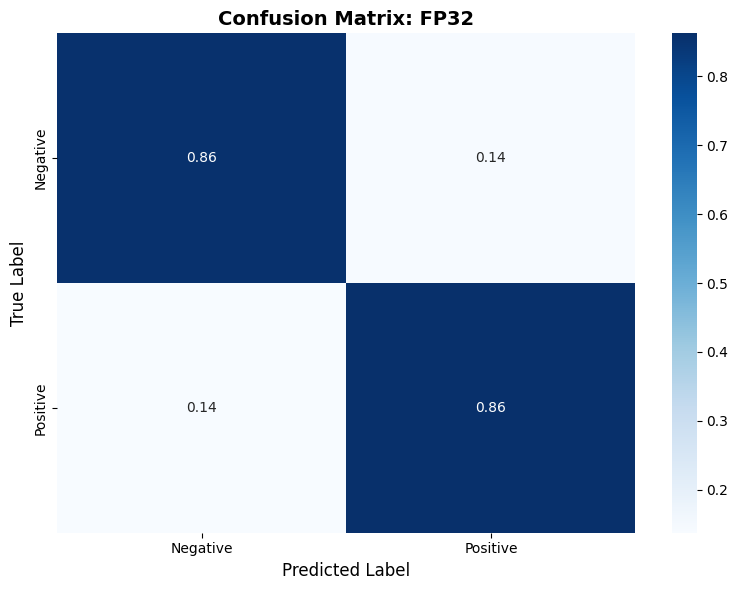

In [22]:
evaluator.save_results(results_fp32, '/kaggle/working/results/fp32_baseline.json')

evaluator.plot_confusion_matrix(
    results=results_fp32,
    save_path='/kaggle/working/results/confusion_matrix_fp32.png',
    class_names=['Negative', 'Positive']
)

## Part 5: Batch-Level Analysis

In [23]:
print("Computing batch-level accuracies...")
batch_accuracies = evaluator.compute_batch_accuracies(
    model=model_fp32,
    dataset=dataset,
    batch_size=8
)

print("\nPer-Batch Accuracies:")
print("="*60)
for i, acc in enumerate(batch_accuracies, 1):
    print(f"Batch {i}: {acc*100:.2f}%")

stats = compute_accuracy_statistics(batch_accuracies)
print("\nBatch Accuracy Statistics:")
print("="*60)
print(f"Mean:   {stats['mean']*100:.2f}%")
print(f"Std:    {stats['std']*100:.2f}%")
print(f"Min:    {stats['min']*100:.2f}%")
print(f"Max:    {stats['max']*100:.2f}%")
print(f"Median: {stats['median']*100:.2f}%")
print(f"95% CI: ±{stats['ci_95']*100:.2f}%")
print("="*60)

Computing batch-level accuracies...

Per-Batch Accuracies:
Batch 1: 87.50%
Batch 2: 87.50%
Batch 3: 75.00%
Batch 4: 87.50%
Batch 5: 87.50%
Batch 6: 87.50%
Batch 7: 100.00%

Batch Accuracy Statistics:
Mean:   87.50%
Std:    6.68%
Min:    75.00%
Max:    100.00%
Median: 87.50%
95% CI: ±4.95%


## Part 6: Detailed Classification Report

In [24]:
all_preds = []
all_labels = []

model_fp32.eval()
with torch.no_grad():
    for batch in dataset.get_batch(8):
        outputs = model_fp32(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

print_classification_report(
    predictions=np.array(all_preds),
    labels=np.array(all_labels),
    class_names=['Negative', 'Positive']
)


Classification Report:
              precision    recall  f1-score   support

    Negative     0.8182    0.8571    0.8372        21
    Positive     0.8929    0.8621    0.8772        29

    accuracy                         0.8600        50
   macro avg     0.8555    0.8596    0.8572        50
weighted avg     0.8615    0.8600    0.8604        50



## Part 7: Log Results to CSV

In [25]:
logger = ResultsLogger(output_dir='/kaggle/working/results')

logger.log_result(
    precision='FP32',
    batch_size=8,
    seq_length=128,
    accuracy=results_fp32.accuracy,
    latency=results_fp32.inference_time,
    throughput=results_fp32.samples_per_second,
    num_samples=results_fp32.num_total,
    notes='Baseline - fine-tuned DistilBERT'
)

logger.log_result(
    precision='FP16',
    batch_size=8,
    seq_length=128,
    accuracy=0.0,
    latency=0.0,
    num_samples=50,
    notes='Waiting for Thomas - FP16 model'
)

logger.log_result(
    precision='INT8',
    batch_size=8,
    seq_length=128,
    accuracy=0.0,
    latency=0.0,
    num_samples=50,
    notes='Waiting for Thomas - INT8 model'
)

logger.print_summary()

logger.save_csv('results.csv')
logger.save_json('results.json')

create_results_template('/kaggle/working/results_template.csv')

ResultsLogger initialized. Output: /kaggle/working/results
✓ Logged: FP32 | Acc: 86.00% | Latency: 0.1158s
✓ Logged: FP16 | Acc: 0.00% | Latency: 0.0000s
✓ Logged: INT8 | Acc: 0.00% | Latency: 0.0000s

RESULTS SUMMARY

Total experiments: 3
Precisions: ['FP32', 'FP16', 'INT8']
Batch sizes: [8]

Accuracy by Precision:
----------------------------------------------------------------------
  FP32  :  86.00%
  FP16  :   0.00%
  INT8  :   0.00%

✓ Results saved to /kaggle/working/results/results.csv
✓ Results saved to /kaggle/working/results/results.json
✓ Results template saved to /kaggle/working/results_template.csv


'/kaggle/working/results_template.csv'

## Part 8: View Results Table

In [26]:
df_results = logger.get_dataframe()
print("\nCurrent Results Table:")
print("="*100)
display(df_results)
print("="*100)


Current Results Table:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,timestamp,precision,batch_size,seq_length,num_samples,accuracy_%,latency_s,throughput_samples_s,avg_power_w,energy_j,energy_per_sample_mj,notes
0,2025-12-01T19:34:36.654188,FP32,8,128,50,86.0,0.1158,431.87,None,None,None,Baseline - fine-tuned DistilBERT
1,2025-12-01T19:34:36.654300,FP16,8,128,50,0.0,0.0000,NaN,None,None,None,Waiting for Thomas - FP16 model
2,2025-12-01T19:34:36.654394,INT8,8,128,50,0.0,0.0000,NaN,None,None,None,Waiting for Thomas - INT8 model


## Part 9: Placeholder for FP16/INT8 Evaluation

**Ready when Thomas provides models - just uncomment and run!**

In [27]:
# UNCOMMENT WHEN THOMAS PROVIDES FP16 MODEL

# # Load FP16 model (Thomas will provide)
# model_fp16 = load_fp16_model()  # Replace with actual loading code
# model_fp16 = model_fp16.to(device)

# # Evaluate FP16
# results_fp16 = evaluator.evaluate(
#     model=model_fp16,
#     dataset=dataset,
#     batch_size=8,
#     precision_type='FP16'
# )

# # Print and save
# print(results_fp16.summary())
# evaluator.save_results(results_fp16, '/kaggle/working/results/fp16_results.json')
# evaluator.plot_confusion_matrix(results_fp16, save_path='/kaggle/working/results/confusion_fp16.png')

# # Log to CSV
# logger.log_result(
#     precision='FP16',
#     batch_size=8,
#     seq_length=128,
#     accuracy=results_fp16.accuracy,
#     latency=results_fp16.inference_time,
#     throughput=results_fp16.samples_per_second,
#     num_samples=results_fp16.num_total
# )

print("FP16 evaluation code ready (currently commented out)")

FP16 evaluation code ready (currently commented out)


In [28]:
# UNCOMMENT WHEN THOMAS PROVIDES INT8 MODEL

# # Load INT8 model (Thomas will provide)
# model_int8 = load_int8_model()  # Replace with actual loading code
# model_int8 = model_int8.to(device)

# # Evaluate INT8
# results_int8 = evaluator.evaluate(
#     model=model_int8,
#     dataset=dataset,
#     batch_size=8,
#     precision_type='INT8'
# )

# # Print and save
# print(results_int8.summary())
# evaluator.save_results(results_int8, '/kaggle/working/results/int8_results.json')
# evaluator.plot_confusion_matrix(results_int8, save_path='/kaggle/working/results/confusion_int8.png')

# # Log to CSV
# logger.log_result(
#     precision='INT8',
#     batch_size=8,
#     seq_length=128,
#     accuracy=results_int8.accuracy,
#     latency=results_int8.inference_time,
#     throughput=results_int8.samples_per_second,
#     num_samples=results_int8.num_total
# )

print("INT8 evaluation code ready (currently commented out)")

INT8 evaluation code ready (currently commented out)


## Part 10: Compare All Precisions

**Uncomment when all models evaluated**

In [29]:
# UNCOMMENT WHEN ALL MODELS EVALUATED

# # Compare all precisions
# comparison = evaluator.compare_precisions([
#     results_fp32,
#     results_fp16,
#     results_int8
# ])

# print("\nComparison Across Precisions:")
# print("="*70)
# for i, prec in enumerate(comparison['precisions']):
#     print(f"\n{prec}:")
#     print(f"  Accuracy:     {comparison['accuracies'][i]*100:.2f}%")
#     print(f"  Throughput:   {comparison['throughputs'][i]:.2f} samples/s")
#     print(f"  Accuracy Drop: {comparison['accuracy_drops'][prec]:.2f}%")

# print(f"\nBest: {comparison['best']['precision']} ({comparison['best']['accuracy']*100:.2f}%)")
# print(f"Worst: {comparison['worst']['precision']} ({comparison['worst']['accuracy']*100:.2f}%)")
# print("="*70)

print("Comparison code ready (currently commented out)")

Comparison code ready (currently commented out)


## Part 11: Summary and Files Generated

In [30]:
# List all generated files
print("\n" + "="*70)
print("FILES GENERATED")
print("="*70)

results_dir = Path('/kaggle/working/results')
if results_dir.exists():
    files = list(results_dir.glob('*'))
    for file in sorted(files):
        size = file.stat().st_size / 1024  # KB
        print(f"  {file.name:40s} {size:8.2f} KB")
else:
    print("  (No results directory yet)")

print("="*70)


FILES GENERATED
  confusion_matrix_fp32.png                   93.78 KB
  fp32_baseline.json                           0.38 KB
  results.csv                                  0.40 KB
  results.json                                 1.05 KB


In [31]:
# Final summary
print("\n" + "="*70)
print("DAY 2 CHECKPOINT COMPLETE")
print("="*70)

print("\n✓ What You Accomplished:")
print("  - FP32 baseline evaluated")
print(f"  - Accuracy: {results_fp32.accuracy*100:.2f}%")
print("  - Confusion matrix generated")
print("  - Per-class accuracy computed")
print("  - Batch-level statistics analyzed")
print("  - Results logged to CSV")
print("  - Code ready for FP16/INT8")

print("\n Waiting For:")
print("  - Thomas: FP16 and INT8 models (Day 3)")
print("  - Krishna: Energy measurements (Day 4-5)")

print("\nKey Files:")
print("  - results.csv - Results table (accuracy filled)")
print("  - fp32_baseline.json - FP32 detailed results")
print("  - confusion_matrix_fp32.png - Visualization")

print("\n" + "="*70)
print("Ready for Day 3!")
print("="*70)


DAY 2 CHECKPOINT COMPLETE

✓ What You Accomplished:
  - FP32 baseline evaluated
  - Accuracy: 86.00%
  - Confusion matrix generated
  - Per-class accuracy computed
  - Batch-level statistics analyzed
  - Results logged to CSV
  - Code ready for FP16/INT8

 Waiting For:
  - Thomas: FP16 and INT8 models (Day 3)
  - Krishna: Energy measurements (Day 4-5)

Key Files:
  - results.csv - Results table (accuracy filled)
  - fp32_baseline.json - FP32 detailed results
  - confusion_matrix_fp32.png - Visualization

Ready for Day 3!
